# Spectral Clustering

This notebook ilustrates spectral clustering (SC). sklearn has already SC implemented, but here I illustrate the basics of its internal procedure.

In [1]:
import numpy as np
import pygraphviz as pgv
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

The next two functions are used to visualize (using graphviz) the graph represented by an adjacency matrix. 

In [2]:
def getGraph(adjMat):
    ''' creates a graphviz graph from an adjacency matrix
    adjMat: (numpy.array) adjacency matrix
    
    returns: graphviz graph
    '''
    elist = []
    for i in range(0, adjMat.shape[0]):
        for j in range(i+1, adjMat.shape[0]):
            if adjMat[i,j] == 1:
                elist.append((str(i), str(j)))
    G=pgv.AGraph()
    G.add_edges_from(elist)
    G.layout()
    return G

def getImg(G):
    ''' creates image from the graphviz graph
    G: graphviz graph
    
    returns: (numpy.array) image
    '''
    G.draw("graph.png")
    im = cv2.imread("graph.png")
    os.remove("graph.png")
    return im

An example of graph:

In [11]:
adjMat=np.array([[0, 1, 0, 0, 1, 1, 0, 0, 0],
                 [1, 0, 1, 1, 0, 0, 0, 0, 0],
                 [0, 1, 0, 1, 0, 0, 0, 0, 0],
                 [0, 1, 1, 0, 0, 0, 0, 0, 0],
                 [1, 0, 0, 0, 0, 1, 0, 0, 0],
                 [1, 0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0 ,0, 0, 0, 0, 1, 1],
                 [0, 0, 0 ,0, 0, 0, 1, 0, 1],
                 [0, 0, 0 ,0, 0, 0, 1, 1, 0]])

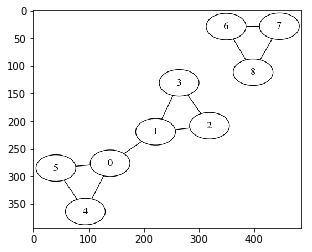

In [13]:
G = getGraph(adjMat)
plt.imshow(getImg(G))

function that color nodes according to their cluster:

In [5]:
group2color = {0:"red", 1:"green", 2:"blue"}

def colorGraph(G, colorList):
    for n in range(len(colorList)):
        node = G.get_node(str(n))
        node.attr["style"] = "filled"
        node.attr["fillcolor"] = group2color[colorList[n]]
    return G

This is where the magic happens. In the next cell I define two functions to compute the Laplacian and normalized Laplacian of the adjacency matrix. After that, I compute the eigenvalues and eigenvectors of the Laplacian and order them by the eigenvalues.

In [14]:
def getLaplacian(adjMat):
    d = np.sum(adjMat, axis=0)
    return np.diag(d) - adjMat

def getSymLaplacianNorm(adjMat):
    '''
    https://en.wikipedia.org/wiki/Laplacian_matrix#Symmetric_normalized_Laplacian
    '''
    L=getLaplacian(adjMat)
    D=np.diag(np.sum(adjMat, axis=0))
    I=np.eye(adjMat.shape[0])
    Dsqrt=np.sqrt(D)
    DinvSqrt=np.linalg.inv(Dsqrt)
    return I - np.dot(np.dot(DinvSqrt, adjMat), DinvSqrt)

In [15]:
L=getLaplacian(adjMat)
w, v = np.linalg.eig(L)
idx = w.argsort()[::-1]
print np.array_str(w[idx], precision=2, suppress_small=True)
print np.array_str(v[:,idx], precision=2, suppress_small=True), 

[ 4.56  3.    3.    3.    3.    3.    0.44 -0.   -0.  ]
[[ 0.66  0.   -0.01  0.52  0.    0.   -0.26 -0.41  0.  ]
 [-0.66  0.   -0.01  0.52  0.    0.    0.26 -0.41  0.  ]
 [ 0.18 -0.71  0.03 -0.57  0.    0.    0.46 -0.41  0.  ]
 [ 0.18  0.71 -0.02  0.06  0.    0.    0.46 -0.41  0.  ]
 [-0.18 -0.02 -0.7  -0.27  0.    0.   -0.46 -0.41  0.  ]
 [-0.18  0.02  0.71 -0.25  0.    0.   -0.46 -0.41  0.  ]
 [ 0.    0.    0.    0.    0.29  0.82  0.    0.   -0.58]
 [ 0.    0.    0.    0.   -0.81 -0.41  0.    0.   -0.58]
 [ 0.    0.    0.    0.    0.51 -0.41  0.    0.   -0.58]]


I pick the eigenvectors corresponding to the smaller eigenvalues. I pick only three of those, since I will create three clusters.

In [16]:
coord=v[:,idx][:,-3:]

Run kmeans in the coordinates:

In [17]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(coord)
print kmeans.labels_

[0 2 2 2 0 0 1 1 1]


And *voilà*, I get clusters in the given graph.

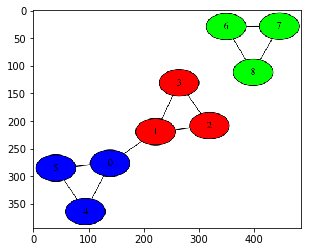

In [18]:
plt.imshow(getImg(colorGraph(G, kmeans.labels_)))